In [1]:
import urllib
import sys
import os
from os.path import expanduser
from datetime import datetime

import json
import geopy
from geopy import *

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib
from matplotlib import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
airnow_key = my_key = open(sys.argv[1]).readlines()[0]

epa_uid = my_key = open(sys.argv[1]).readlines()[1]
eps_pw  = my_key = open(sys.argv[1]).readlines()[2]

In [3]:
#Turn a place name (ex. "Seattle, Washington") into latitude and longitude
def LatLongFromText(location):
    geolocator = Nominatim()
    coded_location = geolocator.geocode(location)
    return (coded_location.latitude, coded_location.longitude)

#Calculate a bounding box around location with a default of 10 miles
def BoundingBox(lat,lng,dist=10.0) :
    #1 deg = 69 mi (or 111 km)
    delta = dist / 69.0  
    return (lat-delta, lng-delta, lat+delta, lng+delta)


In [4]:
def AirNowAPI(llat,llng,ulat,ulng,sdate,stime,edate,etime,file=None):
    # API parameters
    options = {}
    options["url"] = "https://airnowapi.org/aq/data/"
    options["parameters"] = "o3,pm25,pm10,co,no2,so2"
    options["data_type"] = "b"
    options["api_key"] = airnow_key
    options["ext"] = "json"
    options["format"] = "application/json"

    options["start_date"] = sdate
    options["start_hour_utc"] = stime
    options["end_date"] = edate
    options["end_hour_utc"] = etime
    options["bbox"] = ('%f,%f,%f,%f') % (llng, llat, ulng, ulat)
    
    # API request URL
    REQUEST_URL = options["url"] \
                    + "?startdate=" + options["start_date"] \
                    + "t" + options["start_hour_utc"] \
                    + "&enddate=" + options["end_date"] \
                    + "t" + options["end_hour_utc"] \
                    + "&parameters=" + options["parameters"] \
                    + "&bbox=" + options["bbox"] \
                    + "&datatype=" + options["data_type"] \
                    + "&format=" + options["format"] \
                    + "&api_key=" + options["api_key"]

    try:
        # Request AirNowAPI data
        print ("Requesting AirNowAPI data...")

        # User's home directory.
        home_dir = expanduser("~")
        if (file==None) :
            download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S." + options["ext"])
        else :
            download_file_name = file
        download_file = os.path.join(home_dir, download_file_name)

        # Perform the AirNow API data request
        api_data = urllib.request.urlretrieve(REQUEST_URL,download_file)
        
        # Download complete
        print ("Download URL: %s" % REQUEST_URL)
        print ("Download File: %s" % download_file)
    
    except Exception as e:
        print ("Unable perform AirNowAPI request. %s" % e)
        sys.exit(1)
        
    return download_file

def AirNowAPI2(lat,lng,sdate,stime,edate,etime,dist=10.0,file=None):
    llat, llng, ulat, ulng = BoundingBox(lat,lng,dist)
    return AirNowAPI( llat, llng, ulat, ulng, sdate, stime, edate, etime, file ) 

In [5]:
commonradius = 20.0
place1 = 'seattle,wa'
lat , lng = LatLongFromText(place1)
jsonfilename = AirNowAPI2(lat, lng,'2015-09-01','12','2015-09-03','23',commonradius)

file = open(jsonfilename)
json_data1 = json.loads(file.read())

place2 = 'new york,ny'
lat , lng = LatLongFromText(place2)
jsonfilename = AirNowAPI2(lat, lng,'2015-09-01','12','2015-09-03','23',commonradius)

file = open(jsonfilename)
json_data2 = json.loads(file.read())

Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2015-09-01t12&enddate=2015-09-03t23&parameters=o3,pm25,pm10,co,no2,so2&bbox=-122.619917,47.313977,-122.040207,47.893687&datatype=b&format=application/json&api_key=C5E9988D-0A07-4EAD-B3B5-C9E4DCB207C7
Download File: /Users/yamaoka/AirNowAPI_20172106042132.json
Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2015-09-01t12&enddate=2015-09-03t23&parameters=o3,pm25,pm10,co,no2,so2&bbox=-74.276436,40.440744,-73.696726,41.020454&datatype=b&format=application/json&api_key=C5E9988D-0A07-4EAD-B3B5-C9E4DCB207C7
Download File: /Users/yamaoka/AirNowAPI_20172106042147.json


In [6]:
pm25data1 = list(filter(lambda x: x['Parameter']=='PM2.5',json_data1))
pm251 = list(map(lambda x: x['Value'], pm25data1))
date1 = list(map(lambda x: x['UTC'], pm25data1))
datesimp1 = list(set(date1))
pm25avg1 = []
for c in datesimp1 :
    onedaylist = list(filter(lambda x: x['UTC']==c,pm25data1))
    oneday = list(map(lambda x: x['Value'], onedaylist))
    pm25avg1.append(np.mean(oneday))

pm25data2 = list(filter(lambda x: x['Parameter']=='PM2.5',json_data2))
pm252 = list(map(lambda x: x['Value'], pm25data2))
date2 = list(map(lambda x: x['UTC'], pm25data2))
datesimp2 = list(set(date1))
pm25avg2 = []
for c in datesimp2 :
    onedaylist = list(filter(lambda x: x['UTC']==c,pm25data2))
    oneday = list(map(lambda x: x['Value'], onedaylist))
    pm25avg2.append(np.mean(oneday))

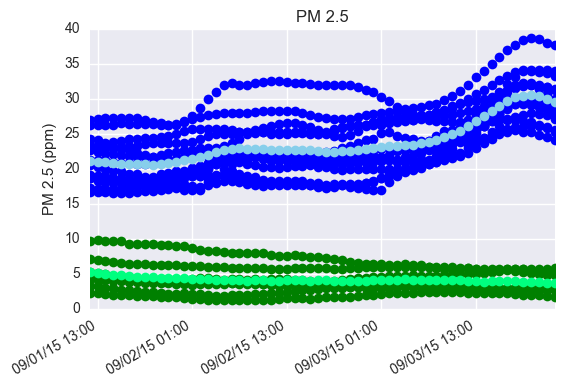

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)  

plt.plot_date(x=date1, y=pm251, color='g')
plt.plot_date(x=date2, y=pm252, color='b')
plt.plot_date(x=datesimp1, y=pm25avg1, color='springgreen')
plt.plot_date(x=datesimp2, y=pm25avg2, color='skyblue')
plt.title("PM 2.5")
plt.ylabel("PM 2.5 (ppm)")
plt.grid(True)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'))     #optional formatting 
fig.autofmt_xdate()
plt.show()


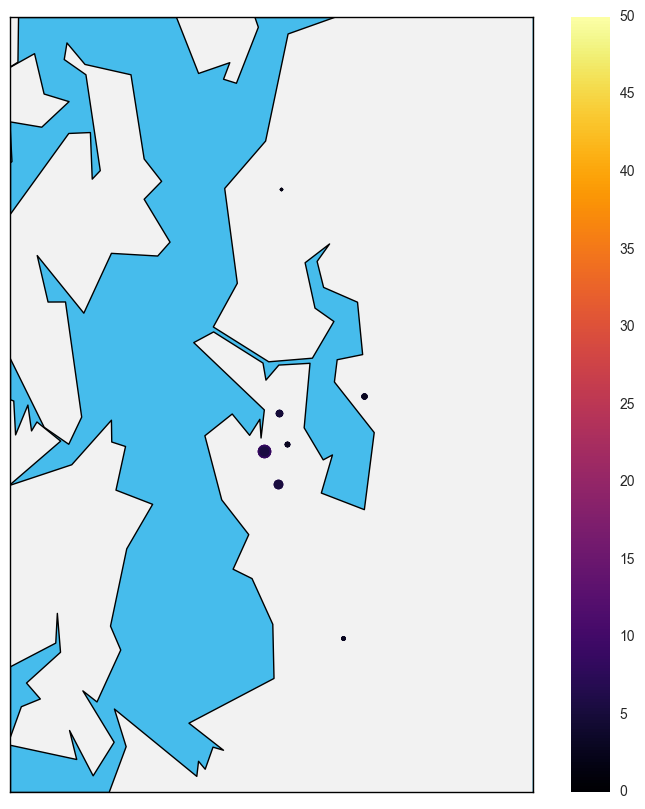

In [8]:
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,10))
lat , lng = LatLongFromText(place1)
llat, llng, ulat, ulng = BoundingBox(lat,lng,25.0)
m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            lat_0=lat, lon_0=lng,
            llcrnrlon=llng, llcrnrlat=llat, urcrnrlon=ulng, urcrnrlat=ulat)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
#m.readshapefile(shpfilename, 'areas')

#cm = plt.get_cmap('inferno')   
#norm = Normalize()
norm = matplotlib.colors.Normalize(vmin=0, vmax=50, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='inferno')

#print (mapper.to_rgba(30.))

def plot_point(loc):
    x,y = m(loc['Longitude'], loc['Latitude'])
    size = loc['Value']
    m.plot(x,y, 'o', markersize=size, color=mapper.to_rgba(size), alpha=0.75)
    
dummy = list( map(plot_point, pm25data1) )

mapper.set_array(pm25data1)
plt.colorbar(mapper)
plt.show()

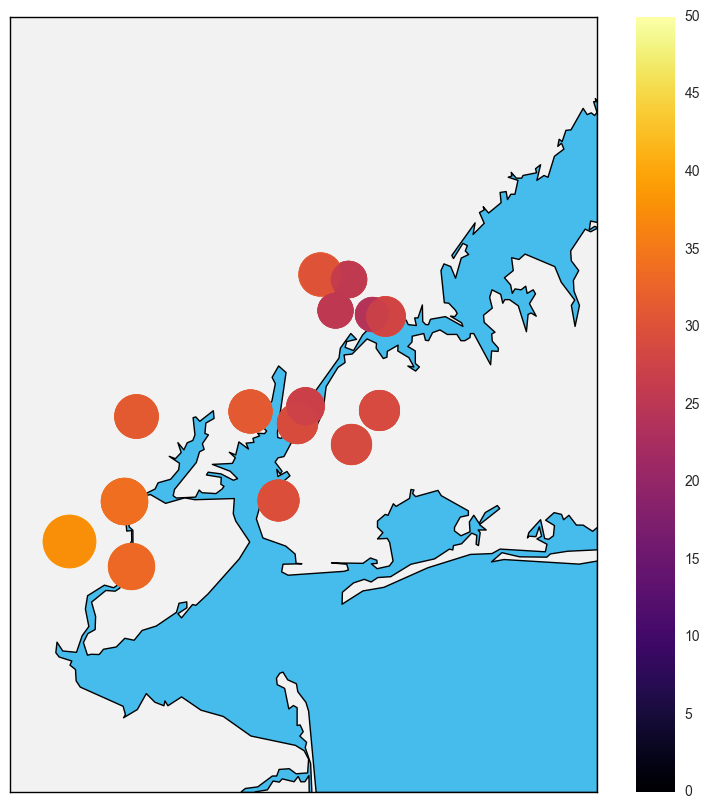

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
lat , lng = LatLongFromText(place2)
llat, llng, ulat, ulng = BoundingBox(lat,lng,25.0)
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=lat, lon_0=lng,
            llcrnrlon=llng, llcrnrlat=llat, urcrnrlon=ulng, urcrnrlat=ulat)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawrivers()
 
dummy = list( map(plot_point, pm25data2) )

mapper.set_array(pm25data1)
plt.colorbar(mapper)
plt.show()